In [143]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import GridSearchCV

In [144]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [145]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [146]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [147]:
y = data['price']

del data['price']

In [148]:
# 전체 데이터를 분석하기 위해 학습과 테스트 데이터를 합친다. 
# 이 때 학습 데이터의 길이를 저장해서 이후 데이터를 분리할 때 사용한다.
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [149]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

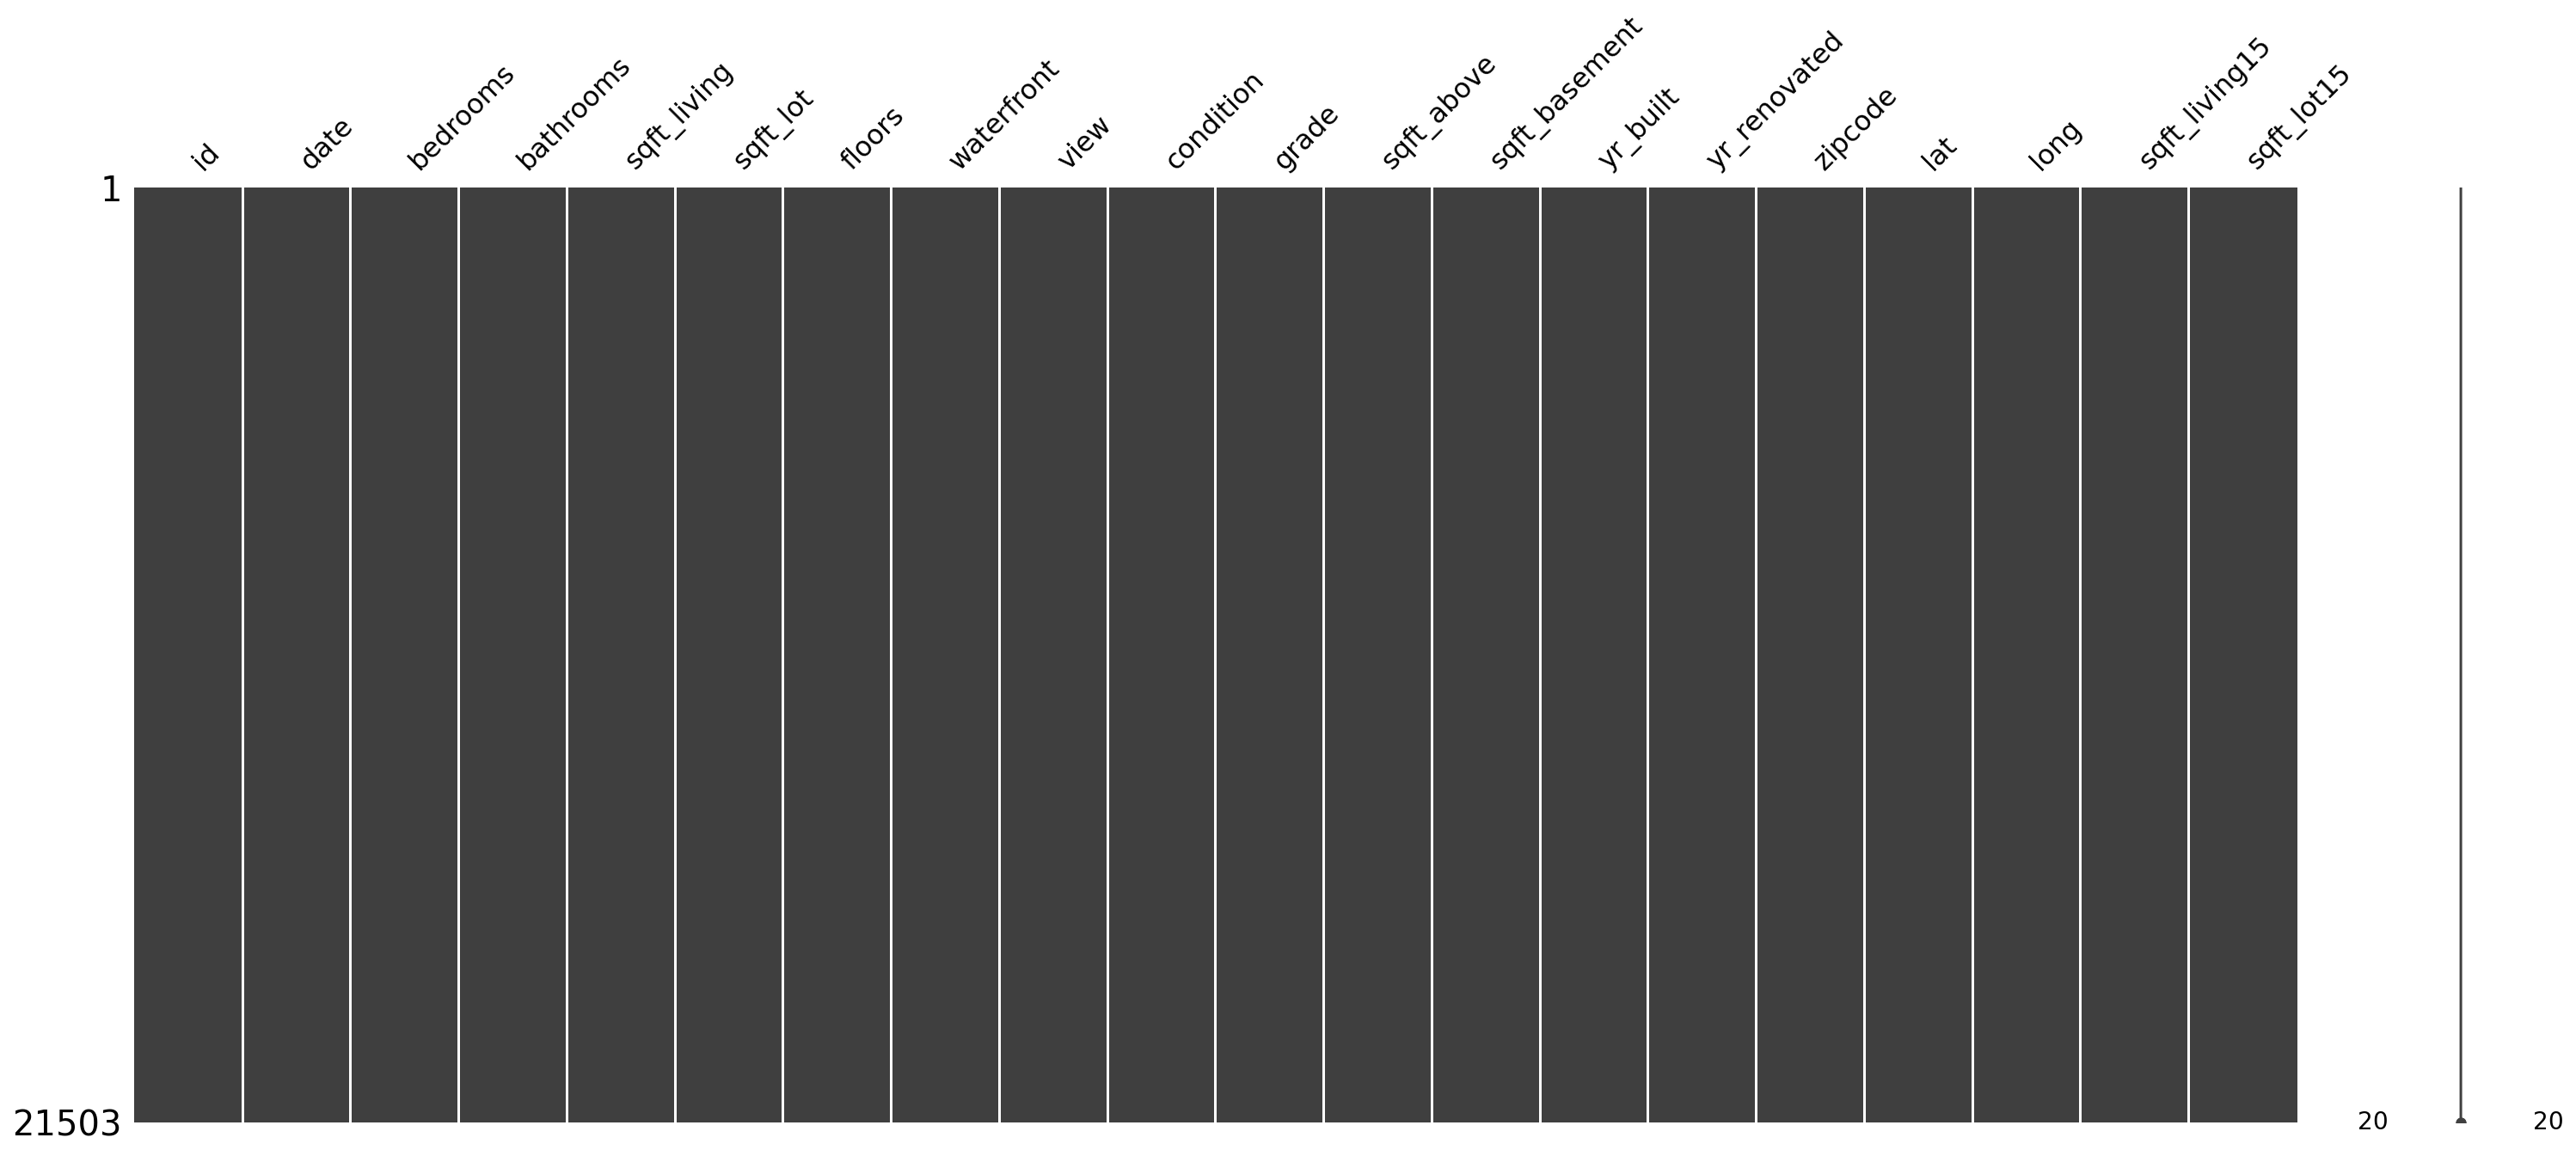

In [150]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [151]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [152]:
sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(int)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21503 non-null  int64  
 1   bedrooms       21503 non-null  int64  
 2   bathrooms      21503 non-null  float64
 3   sqft_living    21503 non-null  int64  
 4   sqft_lot       21503 non-null  int64  
 5   floors         21503 non-null  float64
 6   waterfront     21503 non-null  int64  
 7   view           21503 non-null  int64  
 8   condition      21503 non-null  int64  
 9   grade          21503 non-null  int64  
 10  sqft_above     21503 non-null  int64  
 11  sqft_basement  21503 non-null  int64  
 12  yr_built       21503 non-null  int64  
 13  yr_renovated   21503 non-null  int64  
 14  zipcode        21503 non-null  int64  
 15  lat            21503 non-null  float64
 16  long           21503 non-null  float64
 17  sqft_living15  21503 non-null  int64  
 18  sqft_lo

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

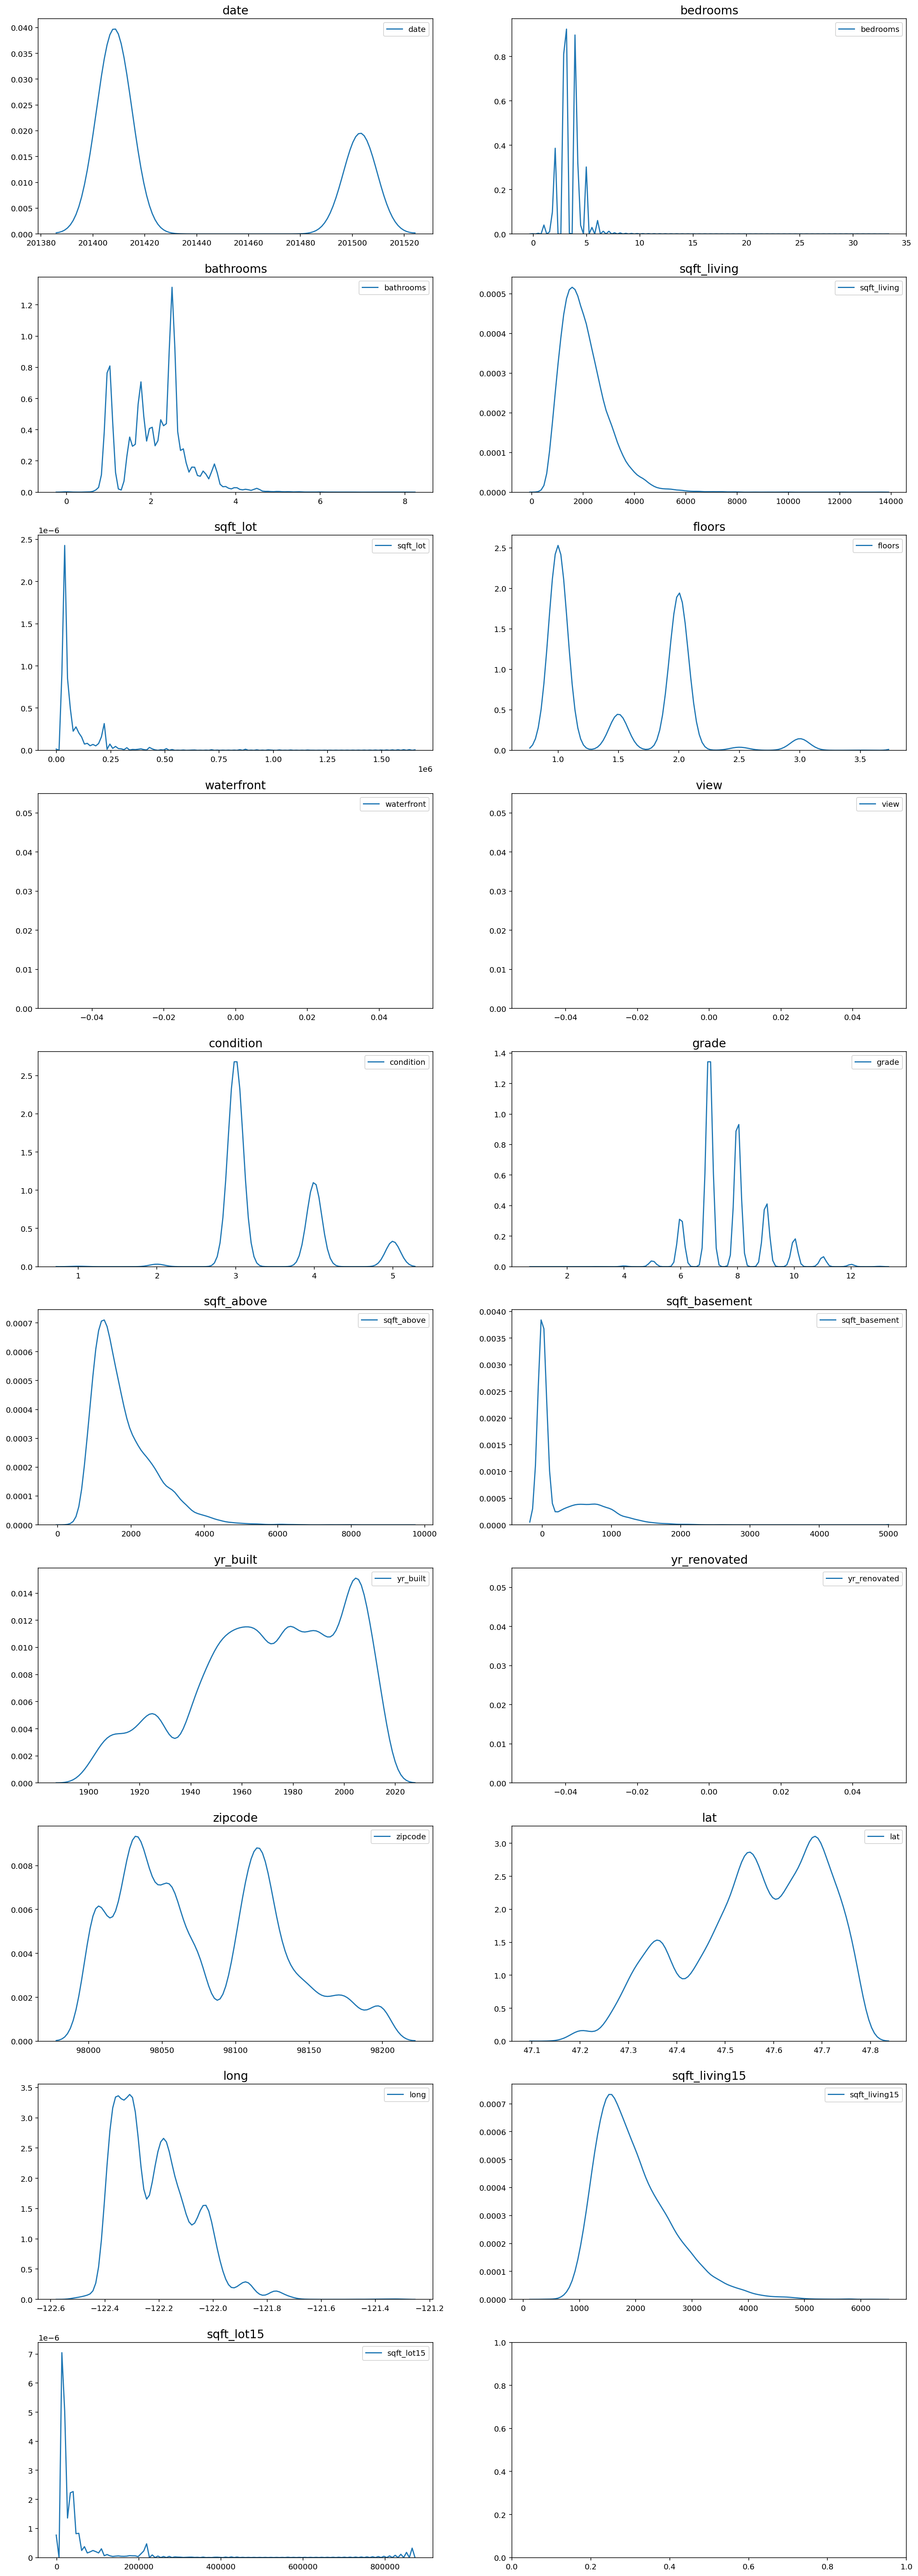

In [153]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [154]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', ]

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

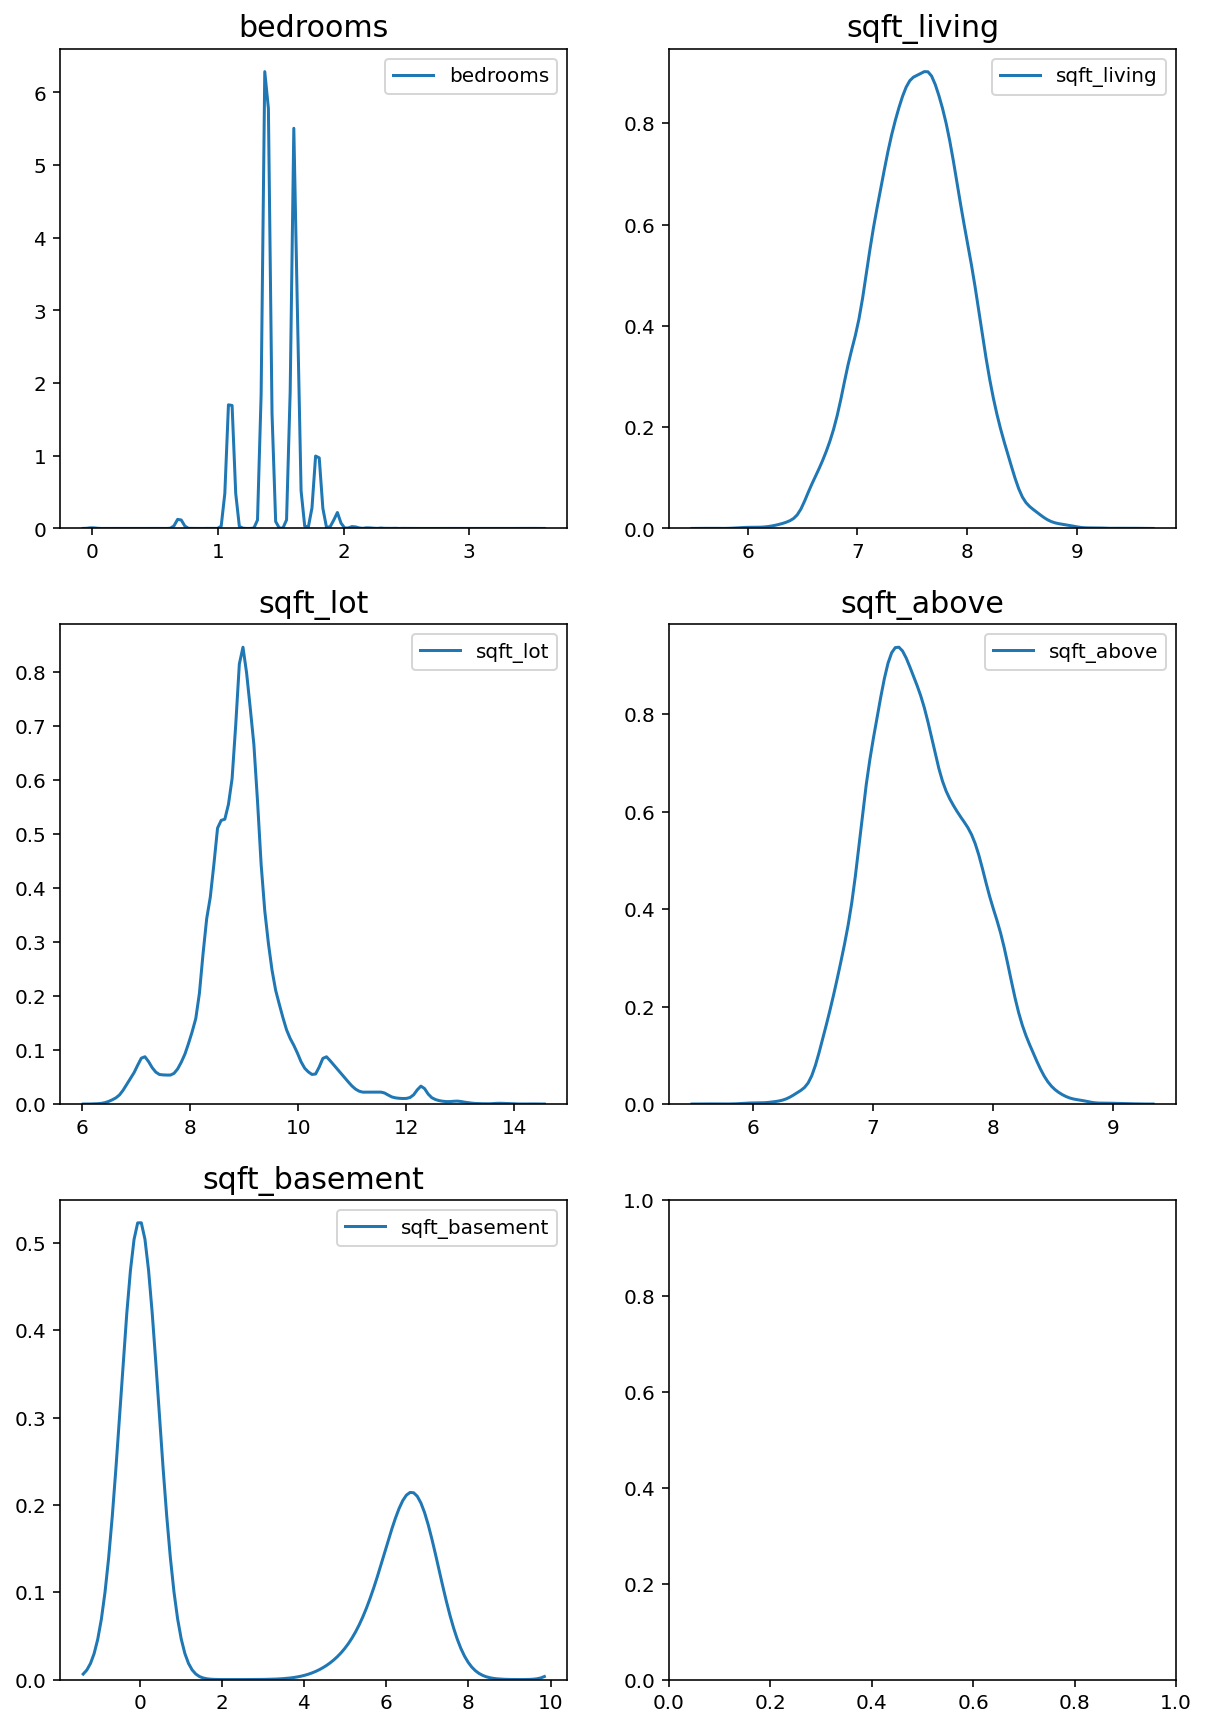

In [155]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1



어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

## standardization

In [156]:
for c in data.columns:
    data[c]= (data[c]-data[c].mean())/data[c].std()

data

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,-0.646762,-0.312366,-1.449371,-1.125316,-0.388528,-0.916615,-0.087395,-0.306109,-0.630259,-0.561266,-0.754072,-0.798002,-0.539349,-0.210564,1.871420,-0.352924,-0.306846,-0.944081,-0.260638
1,1.430859,-1.660408,-1.449371,-2.130052,0.243906,-0.916615,-0.087395,-0.306109,-0.630259,-1.412749,-1.751982,-0.798002,-1.295964,-0.210564,-0.932849,1.282539,-0.136432,1.068815,-0.172399
2,1.430859,-0.312366,-0.150700,-0.293525,0.007740,-0.916615,-0.087395,-0.306109,-0.630259,0.290216,0.072067,-0.798002,0.546125,-0.210564,-0.072873,0.408897,1.198479,-0.273116,-0.192849
3,-0.737093,-0.312366,0.173967,-0.244971,-0.180217,0.934608,-0.087395,-0.306109,-0.630259,-0.561266,0.120291,-0.798002,0.814764,-0.210564,-1.400227,-1.806588,-0.803888,0.365760,-0.217872
4,1.408276,-0.312366,-0.800036,-1.377778,0.211420,-0.916615,-0.087395,-0.306109,-0.630259,-0.561266,-1.004820,-0.798002,-0.266325,-0.210564,2.245322,-1.086610,-0.718681,-0.491909,-0.112074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,-0.737093,-0.312366,-0.475368,-0.560378,0.442919,-0.916615,-0.087395,-0.306109,-0.630259,-1.412749,-0.192973,-0.798002,1.448489,-0.210564,-1.269361,-1.808031,1.503804,-0.973254,-0.053833
6464,1.408276,-0.312366,-0.150700,-0.576128,-2.174725,2.785831,-0.087395,-0.306109,-0.630259,0.290216,-0.208616,-0.798002,1.448489,-0.210564,1.235786,0.070550,-0.526965,-0.856564,-0.422335
6465,1.430859,-0.312366,0.498635,-0.879265,-2.020784,0.934608,-0.087395,-0.306109,-0.630259,0.290216,-0.754072,0.739438,1.249013,-0.210564,0.712322,0.123936,-1.386136,-0.958667,-0.421055
6466,-0.737093,-1.660408,-1.774039,-1.468324,-1.973883,0.934608,-0.087395,-0.306109,-0.630259,-0.561266,-1.094750,-0.798002,1.282301,-0.210564,1.235786,0.247299,-0.605071,-1.410840,-0.393910


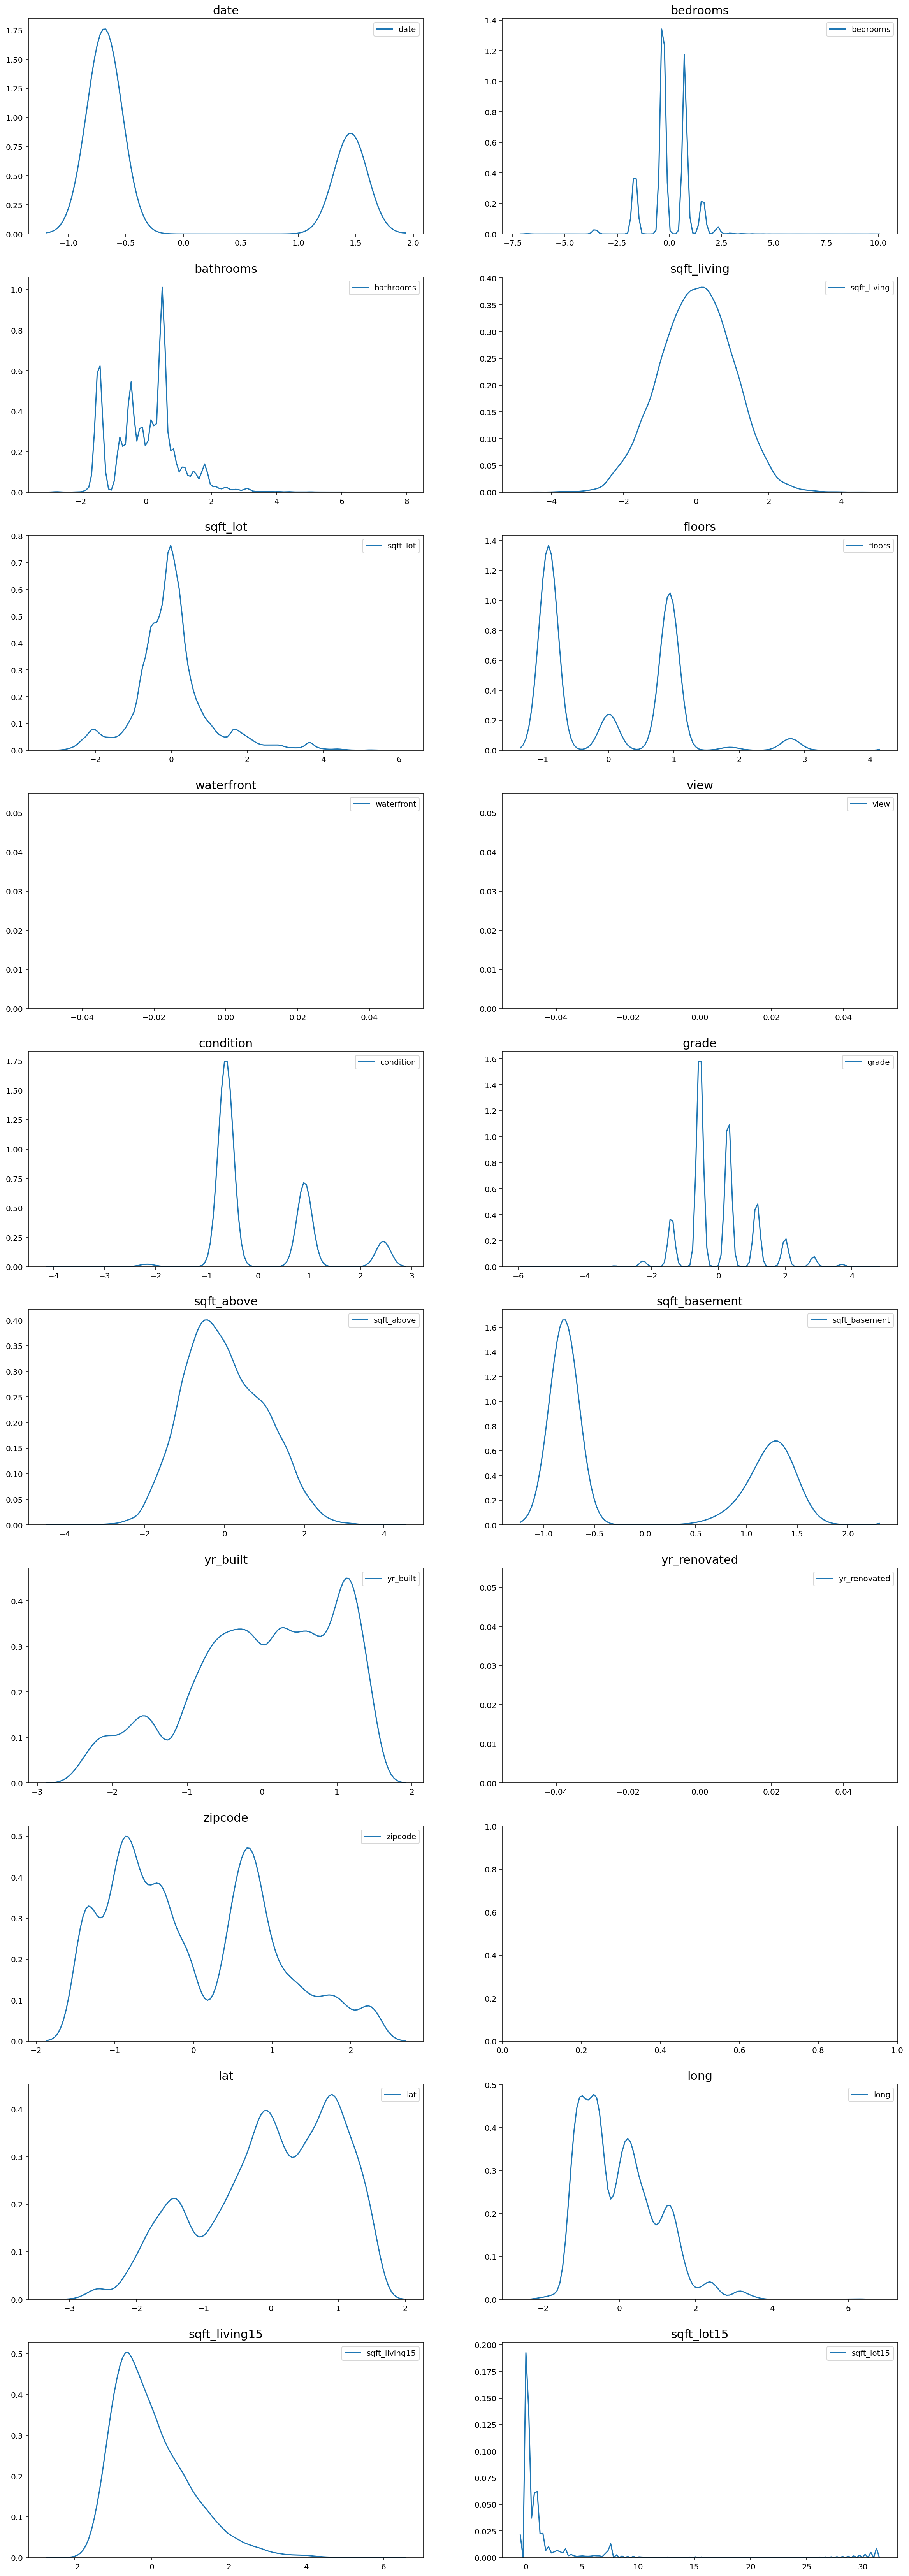

In [157]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 15 :
            break

In [158]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

## Hyperparameter Tuning

### 1. lightgbm

In [66]:
random_state = 2020

In [218]:
random_state = 2020
param_grid = {
    'n_estimators': [50, 75, 100],   # lightgbm
    'max_depth': [1, 10,1000, -1],
    'learning_rate' : [0.005, 0.01, 0.05, 0.1, 0.5],
    'num_leaves' : [10, 20, 30, 40, 50],
    'boosting_type' : ['gbdt', 'rf']
}

model = LGBMRegressor(random_state=random_state)


a = my_GridSearch(model, x, y, param_grid, verbose=2, n_jobs=8)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 432 tasks      | elapsed:    9.7s
[Parallel(n_jobs=8)]: Done 1020 tasks      | elapsed:   22.7s
[Parallel(n_jobs=8)]: Done 2152 tasks      | elapsed:   35.2s
[Parallel(n_jobs=8)]: Done 3000 out of 3000 | elapsed:   38.2s finished


In [220]:
a.head(10)

,boosting_type,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
237,gbdt,0.1,-1,100,30,-1.621512e+10,127338.607688
222,gbdt,0.1,1000,100,30,-1.621512e+10,127338.607688
208,gbdt,0.1,10,100,40,-1.625569e+10,127497.816903
207,gbdt,0.1,10,100,30,-1.625803e+10,127506.992596
206,gbdt,0.1,10,100,20,-1.635765e+10,127897.034299
209,gbdt,0.1,10,100,50,-1.639995e+10,128062.297008
223,gbdt,0.1,1000,100,40,-1.645058e+10,128259.798863
238,gbdt,0.1,-1,100,40,-1.645058e+10,128259.798863
232,gbdt,0.1,-1,75,30,-1.645677e+10,128283.945184
217,gbdt,0.1,1000,75,30,-1.645677e+10,128283.945184


### 2. xgboost

In [77]:

param_grid = {
    'n_estimators': [100, 150, 200],   # lightgbm
    'max_depth': [1, 10,1000, -1],
    'learning_rate' : [0.001, 0.01, 0.1],
    'num_leaves' : [10, 20, 30, 40, 50],
    'boosting_type' : ['gbdt', 'rf']
}

model = xgb.XGBRegressor(random_state=random_state)


a = my_GridSearch(model, x, y, param_grid, verbose=2, n_jobs=8)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   30.0s
[Parallel(n_jobs=8)]: Done 525 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 942 tasks      | elapsed:  4.9min
[Parallel(n_jobs=8)]: Done 1437 tasks      | elapsed:  7.3min
[Parallel(n_jobs=8)]: Done 1800 out of 1800 | elapsed:  9.8min finished


[10:20:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/learner.cc:480: 
Parameters: { boosting_type, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [78]:
a.head(10)

,boosting_type,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
146,gbdt,0.1,10,200,20,-1.671755e+10,129296.370792
147,gbdt,0.1,10,200,30,-1.671755e+10,129296.370792
148,gbdt,0.1,10,200,40,-1.671755e+10,129296.370792
329,rf,0.1,10,200,50,-1.671755e+10,129296.370792
328,rf,0.1,10,200,40,-1.671755e+10,129296.370792
327,rf,0.1,10,200,30,-1.671755e+10,129296.370792
326,rf,0.1,10,200,20,-1.671755e+10,129296.370792
325,rf,0.1,10,200,10,-1.671755e+10,129296.370792
149,gbdt,0.1,10,200,50,-1.671755e+10,129296.370792
145,gbdt,0.1,10,200,10,-1.671755e+10,129296.370792


## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [173]:
from sklearn.linear_model import LinearRegression

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = xgb.XGBRegressor(random_state=random_state)
lightgbm = lgb.LGBMRegressor(random_state=random_state)
linearRegression = LinearRegression()
models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'},{'model':linearRegression, 'name':'LinearRegression'}]


In [174]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=random_state).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                                  kf=kfold))

In [90]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8608
Model XGBoost CV score : 0.8861
Model LightGBM CV score : 0.8819


In [161]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8609
Model XGBoost CV score : 0.8861
Model LightGBM CV score : 0.8821


In [175]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8609
Model XGBoost CV score : 0.8861
Model LightGBM CV score : 0.8821
Model LinearRegression CV score : 0.6655


### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [162]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [163]:
y_pred = AveragingBlending(models, x, y, sub)

In [164]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [166]:
sub.to_csv('submission.csv', index=False)